# **Imports, Settings, Globals**

In [ ]:
# import data management
import numpy as np
import pandas as pd
# from google.colab import files
from collections import Counter

# import visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

# import data processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
# import models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.neural_network import MLPRegressor

# import performance metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

# import basic functions
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# paths
BUILDINGPATH = 'll84_2020.csv'
COUNTRY_EMISSIONS_PATH = 'annual-co2-emissions-per-country.csv' 

# setting
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
clear_output()

# Background Visualization (Country Emissions/World Emissions)

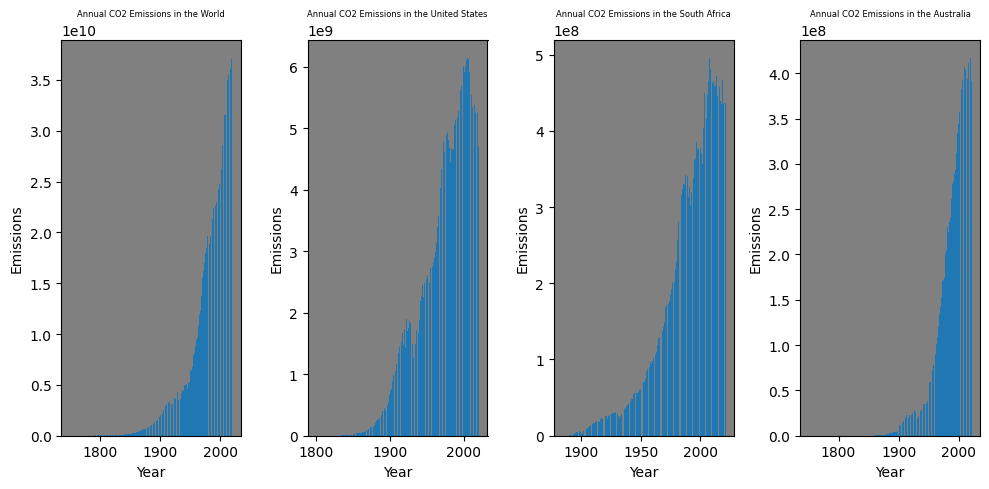

In [ ]:
df_country= pd.read_csv(COUNTRY_EMISSIONS_PATH)
df_country.columns = ['country','code','year','annual_co2_emissions']
grouped = df_country.groupby(by='country')
g = ['World','United States','South Africa', 'Australia']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (10, 5))
for i in range(4):
  tmp = grouped.get_group(g[i])
  ax[i].bar(tmp.year,tmp.annual_co2_emissions)
  ax[i].set_xlabel('Year')
  ax[i].set_ylabel('Emissions')
  ax[i].set_title(label ='Annual CO2 Emissions in the {}'.format(g[i]), fontsize = 6)
  ax[i].set_facecolor('grey')
plt.tight_layout()

# **Read in Data**

In [ ]:
# read in the data and view head()
df = pd.read_csv(BUILDINGPATH)
df.head()

,Property Id,Property Name,Parent Property Id,Parent Property Name,Year Ending,"NYC Borough, Block and Lot (BBL)",NYC Building Identification Number (BIN),Address 1,City,Postcode,Primary Property Type - Self Selected,Primary Property Type - Portfolio Manager-Calculated,National Median Reference Property Type,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Construction Status,Number of Buildings,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,National Median ENERGY STAR Score,Target ENERGY STAR Score,Reason(s) for No Score,ENERGY STAR Certification - Year(s) Certified (Score),ENERGY STAR Certification - Eligibility,ENERGY STAR Certification - Last Approval Date,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),National Median Site EUI (kBtu/ft²),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),National Median Source EUI (kBtu/ft²),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Propane Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Natural Gas Use (therms),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kWh),Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kBtu),Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kWh),Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kBtu),Electricity Use – Generated from Onsite Renewable Systems (kWh),Electricity Use – Generated from Onsite Renewable Systems and Exported (kWh),Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Annual Maximum Demand (Meter Name (Meter ID)),Green Power - Onsite (kWh),Green Power - Offsite (kWh),Green Power - Onsite and Offsite (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/ft²),Direct GHG Emissions Intensity (kgCO2e/ft²),Indirect GHG Emissions (Metric Tons CO2e),Net Emissions (Metric Tons CO2e),Indirect GHG Emissions Intensity (kgCO2e/ft²),National Median Total GHG Emissions (Metric Tons CO2e),eGRID Output Emissions Rate (kgCO2e/MBtu),Avoided Emissions - Onsite Green Power (Metric Tons CO2e),Avoided Emissions - Offsite Green Power (Metric Tons CO2e),Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e),Percent of Electricity that is Green Power,Percent of RECs Retained,Percent of Total Electricity Generated from Onsite Renewable Systems,LEED US Project ID,Adult Education - Gross Floor Area (ft²),Ambulatory Surgical Center - Gross Floor Area (ft²),Automobile Dealership - Gross Floor Area (ft²),Bank Branch - Gross Floor Area (ft²),Barracks- Gross Floor Area (ft²),College/University - Gross Floor Area (ft²),Convention Center - Gross Floor Area (ft²),Courthouse - Gross Floor Area (ft²),Data Center - Gross Floor Area (ft²),Data Center - UPS System Redundancy,Data Center - Cooling Equipment Redundancy,Data Center - IT Energy Configuration,Data Center - Energy Estimates Applied,Data Center - UPS Output Meter (kWh),Data Center - PDU Input Meter (kWh),Data Center - PDU Output Meter (kWh),Data Center - IT Equipment Input Meter (kWh),Data Center - IT Site Energy (kWh),Data Center - IT Source Energy (kBtu),Data Center - PUE,Data C

# Helper Functions

In [ ]:
def basic_stats(df):
    """
    Input: df=dataframe
    Process: obtain shape, #cols, #rows, #cells, #NULLS, #str(NA)
    Output: print the results
    """
    # view shape
    print('Number of observations: ', df.shape[0])
    print('Number of features/labels: ', df.shape[1])
    print('Total cells (col * row):' , df.shape[0] * df.shape[1])

    # view NULL values
    print('Number of NULL entries: ', df.isnull().sum().sum())
    print('Percentage of NULL entries: ', df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))

    # View "Not Available Counts"
    # Note: There are alot of str('Not Available') entries, this is expected.
    na = 0
    for i in df.columns:
        try:
            na += df[i].value_counts()['Not Available']
        except:
            pass
    print('Number of "Not Available" entries: ', na)
    print('Percentage of "Not Available entries: ', na/(df.shape[0]*df.shape[1]))



In [ ]:
def encode(df, categorical_cols):
    """
    Input: df=dataframe, categorical_cols=list[str] after cleaning and dropping
    Process: encode categorical variables
    Output: return dataframe
    """
    data = df.copy(deep = True)
    encoder = LabelEncoder()
    # preprocessing
    for i in categorical_cols:
        data[i] = encoder.fit_transform(data[i])
    return data

In [ ]:
def tts(df, test_size = 0.15, feat_method = None, k_best = 100, n_components = 50):
    """
    Input: df=dataframe, test_size = float, k_best=int
    Process: split dataframe into X & Y according to test_size
             If the feat_method in ['SelectKBest', 'PCA'], perform that method.
             Note: SelectKBest will use mutual_info_regression scoring
    Output: Return x_train, x_test, y_train, y_test 
    """
    X = df[[x for x in df.columns if x != 'Net Emissions (Metric Tons CO2e)']]
    Y = df['Net Emissions (Metric Tons CO2e)']
    if feat_method == 'SelectKBest':
        X = SelectKBest(mutual_info_regression, k=k_best).fit_transform(X, Y)
    elif feat_method =='PCA':
        pca = PCA(n_components = n_components)
        X= pca.fit_transform(X)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 1)
    return pd.DataFrame(x_train), pd.DataFrame(x_test), pd.DataFrame(y_train), pd.DataFrame(y_test)

In [ ]:
def scale(x_train, x_test, numerical_cols):
    """
    Input: x_train=dataframe/array, x_test = dataframe/array, numerical_cols=list[str]
    Process: create scalars
             StandardScaler to transform values closer to normal distribution
             MinMaxScaler to transform values to tighter range
    Output: return x_train, y_train as dataframes
    """
    ss = StandardScaler()
    mm = MinMaxScaler()
    x_train = ss.fit_transform(x_train)
    x_train = mm.fit_transform(x_train)
    x_test = ss.fit_transform(x_test)
    x_test = mm.fit_transform(x_test)
    return pd.DataFrame(x_train), pd.DataFrame(x_test)

In [ ]:
def eval(model, x_train, y_train, x_test, y_test):
    """
    Input: model, x_train=dataframe, y_train=dataframe, x_test=dataframe, y_test=dataframe
    Process: fit model on x_train, y_train
             predict on x_test
             obtain a dictionary of results
    Output: return dictionary of results
    """
    # encoding
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    res = {'MAE': round(mean_absolute_error(y_test, y_pred),5),
           'R^2': round(r2_score(y_test, y_pred),5),
           'Adjusted-R^2': round(1 - ( 1-model.score(x_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - x_test.shape[1] - 1 ), 5),
           'Explained Variance Score': round(explained_variance_score(y_test, y_pred),5)}
    return res

In [ ]:
def store(res, name, overall_result = pd.DataFrame()):
    """
    Input: res=dictionary, name=str, overall_result=dataframe
    Process: create a new dataframe from result dictionary
             Concatenate a previous dataframe of results if given
    Output: return new dataframe
    """
    df = pd.DataFrame(res, index = [name])
    return pd.concat([overall_result, df], axis = 0)

# **View Initial Data** (Before data cleaning)

In [ ]:
# view basic stats of entire dataset
basic_stats(df)

Number of observations:  12849
Number of features/labels:  250
Total cells (col * row): 3212250
Number of NULL entries:  3555
Percentage of NULL entries:  0.0011067009105766986
Number of "Not Available" entries:  1792354
Percentage of "Not Available entries:  0.5579746283757491


In [ ]:
# view basic stats of numeric features
df.describe(exclude = 'object')

,Property Id,Year Built,Number of Buildings,Occupancy,National Median ENERGY STAR Score,Property GFA - Self-Reported (ft²),Number of Active Energy Meters - Total,Number of Active Energy Meters - Used to Compute Metrics,Number of Active Energy Meters - Not Used to Compute Metrics,Number of Active IT Meters,Community Board,Council District,Census Tract,Longitude,Latitude
count,12849.00000,12849.00000,12849.00000,12849.00000,12849.00000,12848.00000,12848.00000,12848.00000,12848.00000,12848.00000,12380.00000,12380.00000,12380.00000,12380.00000,12380.00000
mean,3779269.77212,1948.74667,1.26025,98.40921,50.00000,158093.83562,7.20058,6.89002,0.31055,0.00755,225.64443,18.28732,7484.71034,-73.93858,40.74877
std,1385939.68774,31.45373,3.77392,8.59365,0.00000,349285.85210,11.66026,11.41442,1.64738,0.15440,120.79695,15.06727,20287.08713,0.06321,0.07690
min,7365.00000,1649.00000,0.00000,0.00000,50.00000,0.00000,0.00000,0.00000,0.00000,0.00000,101.00000,1.00000,1.00000,-74.24412,40.50904
25%,2715986.00000,1926.00000,1.00000,100.00000,50.00000,61000.00000,4.00000,4.00000,0.00000,0.00000,107.00000,4.00000,116.00000,-73.98025,40.70630
50%,3387665.00000,1940.00000,1.00000,100.00000,50.00000,88519.50000,5.00000,5.00000,0.00000,0.00000,206.00000,14.00000,251.00000,-73.95332,40.75223
75%,4896837.00000,1967.00000,1.00000,100.00000,50.00000,150746.25000,8.00000,7.00000,0.00000,0.00000,314.00000,30.00000,774.00000,-73.90413,40.80283
max,6272406.00000,2019.00000,161.00000,100.00000,50.00000,21150159.00000,467.00000,449.00000,62.00000,8.00000,503.00000,51.00000,157903.00000,-73.70094,40.91287


In [ ]:
# view basic stats of categorical features
df.describe(exclude = ['float64', 'int64'])

,Property Name,Parent Property Id,Parent Property Name,Year Ending,"NYC Borough, Block and Lot (BBL)",NYC Building Identification Number (BIN),Address 1,City,Postcode,Primary Property Type - Self Selected,Primary Property Type - Portfolio Manager-Calculated,National Median Reference Property Type,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Construction Status,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Target ENERGY STAR Score,Reason(s) for No Score,ENERGY STAR Certification - Year(s) Certified (Score),ENERGY STAR Certification - Eligibility,ENERGY STAR Certification - Last Approval Date,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),National Median Site EUI (kBtu/ft²),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),National Median Source EUI (kBtu/ft²),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Propane Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Natural Gas Use (therms),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kWh),Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kBtu),Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kWh),Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kBtu),Electricity Use – Generated from Onsite Renewable Systems (kWh),Electricity Use – Generated from Onsite Renewable Systems and Exported (kWh),Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Annual Maximum Demand (Meter Name (Meter ID)),Green Power - Onsite (kWh),Green Power - Offsite (kWh),Green Power - Onsite and Offsite (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/ft²),Direct GHG Emissions Intensity (kgCO2e/ft²),Indirect GHG Emissions (Metric Tons CO2e),Net Emissions (Metric Tons CO2e),Indirect GHG Emissions Intensity (kgCO2e/ft²),National Median Total GHG Emissions (Metric Tons CO2e),eGRID Output Emissions Rate (kgCO2e/MBtu),Avoided Emissions - Onsite Green Power (Metric Tons CO2e),Avoided Emissions - Offsite Green Power (Metric Tons CO2e),Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e),Percent of Electricity that is Green Power,Percent of RECs Retained,Percent of Total Electricity Generated from Onsite Renewable Systems,LEED US Project ID,Adult Education - Gross Floor Area (ft²),Ambulatory Surgical Center - Gross Floor Area (ft²),Automobile Dealership - Gross Floor Area (ft²),Bank Branch - Gross Floor Area (ft²),Barracks- Gross Floor Area (ft²),College/University - Gross Floor Area (ft²),Convention Center - Gross Floor Area (ft²),Courthouse - Gross Floor Area (ft²),Data Center - Gross Floor Area (ft²),Data Center - UPS System Redundancy,Data Center - Cooling Equipment Redundancy,Data Center - IT Energy Configuration,Data Center - Energy Estimates Applied,Data Center - UPS Output Meter (kWh),Data Center - PDU Input Meter (kWh),Data Center - PDU Output Meter (kWh),Data Center - IT Equipment Input Meter (kWh),Data Center - IT Site Energy (kWh),Data Center - IT Source Energy (kBtu),Data Center - PUE,Data Center - National Median PUE,Distribution Center - Gross Floor Area (ft²),Enclosed Mall 

In [ ]:
# view column information
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12849 entries, 0 to 12848
Data columns (total 250 columns):
 #    Column                                                                                                             Dtype  
---   ------                                                                                                             -----  
 0    Property Id                                                                                                        int64  
 1    Property Name                                                                                                      object 
 2    Parent Property Id                                                                                                 object 
 3    Parent Property Name                                                                                               object 
 4    Year Ending                                                                                                   

# **Data Cleaning**

In [ ]:
# first, since we are predicting net emissions of CO2, we can't have any missing labels
df = pd.read_csv(BUILDINGPATH)
df = df[df['Net Emissions (Metric Tons CO2e)'] != 'Not Available'].dropna(subset=['Net Emissions (Metric Tons CO2e)'])
print('Shape of dataset with complete labels: ', df.shape)

Shape of dataset with complete labels:  (27897, 250)


In [ ]:
# Drop these features since they are correlated with target variable 
df.drop(['Total GHG Emissions (Metric Tons CO2e)',
          'Direct GHG Emissions (Metric Tons CO2e)',
          'Total GHG Emissions Intensity (kgCO2e/ft²)',
          'Direct GHG Emissions Intensity (kgCO2e/ft²)',
          'Indirect GHG Emissions (Metric Tons CO2e)',
          'Indirect GHG Emissions Intensity (kgCO2e/ft²)',
          'National Median Total GHG Emissions (Metric Tons CO2e)',
          'Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)'], axis = 1, inplace = True)

In [ ]:
# feature dropping based on given indicators and alerts 

# view any possible indicators of incomplete observations
print(df['Alert - Data Center Issue (with Estimates, IT Configuration, or IT Meter)'].value_counts())
print('-'*100)
print(df['Alert - Energy Meter has less than 12 full calendar months of data'].value_counts())
print('-'*100)
print(df['Alert - Energy Meter has gaps'].value_counts())
print('-'*100)
print(df['Alert - Energy Meter has overlaps'].value_counts())
print('-'*100)
print(df['Alert - Energy - No meters selected for metrics'].value_counts())
print('-'*100)
print(df['Alert - Energy Meter has single entry more than 65 days'].value_counts())
print('-'*100)
print(df['Alert - Property has no uses'].value_counts())
print('-'*100)
print(df['Alert - Water Meter has less than 12 full calendar months of data'].value_counts())
print('-'*100)

# drop observations that are flagged by alerts
df = pd.read_csv(BUILDINGPATH)
print('Previous shape: ', df.shape)
df = df[df['Alert - Data Center Issue (with Estimates, IT Configuration, or IT Meter)'] == 'Ok']
df = df[df['Alert - Energy Meter has less than 12 full calendar months of data'] == 'Ok']
df = df[df['Alert - Energy Meter has gaps'] == 'Ok']
df = df[df['Alert - Energy Meter has overlaps'] == 'Ok']
df = df[df['Alert - Energy - No meters selected for metrics'] == 'Ok']
df = df[df['Alert - Energy Meter has single entry more than 65 days'] == 'Ok']
df = df[df['Alert - Property has no uses'] == 'Ok']
df = df[df['Alert - Water Meter has less than 12 full calendar months of data'] =='Ok']
print('Shape after dropping triggered alerts: ', df.shape)

Ok                27891
Possible Issue        6
Name: Alert - Data Center Issue (with Estimates, IT Configuration, or IT Meter), dtype: int64
----------------------------------------------------------------------------------------------------
Ok                                   27259
Unable to Check (not enough data)      597
Possible Issue                          41
Name: Alert - Energy Meter has less than 12 full calendar months of data, dtype: int64
----------------------------------------------------------------------------------------------------
Ok                                   27299
Unable to Check (not enough data)      597
Possible Issue                           1
Name: Alert - Energy Meter has gaps, dtype: int64
----------------------------------------------------------------------------------------------------
Ok                                   27297
Unable to Check (not enough data)      597
Possible Issue                           3
Name: Alert - Energy Meter has 

In [ ]:
# Feature Dropping (continued): based dropping redundant features, and un-used features
# Note: this section was determined by common sense.
# Ex: some are non-indicative, like property name, there are multiple id features, generation date of data,

print('Previous shape: ', df.shape)
df.drop(['Property Id','Property Name','Parent Property Id','Parent Property Name','Year Ending','NYC Building Identification Number (BIN)','Address 1','Construction Status','Reason(s) for No Score',
         'ENERGY STAR Certification - Last Approval Date','LEED US Project ID','Release Date','Generation Date','Number of Active Energy Meters - Not Used to Compute Metrics','Number of Active IT Meters',
         'Annual Maximum Demand (MM/YYYY)','Percent of RECs Retained','Last Modified Date - Property Use','Last Modified Date - Water Meters','Last Modified Date - Non-Electric Non-Gas Energy Meters','Last Modified Date - Gas Meters','Last Modified Date - Electric Meters',
         'Last Modified Date - Property','Third Party Certification Date Achieved','Third Party Certification Date Anticipated','Third Party Certification','Temporary Values','Default Values','Municipally Supplied Potable Water - Outdoor Use (kgal)',
         'Outdoor Water Use (All Water Sources) (kgal)','Alert - Data Center Issue (with Estimates, IT Configuration, or IT Meter)','Alert - Energy Meter has less than 12 full calendar months of data',
         'Alert - Energy Meter has gaps','Alert - Energy Meter has overlaps','Alert - Energy - No meters selected for metrics','Alert - Energy Meter has single entry more than 65 days',
         'Alert - Property has no uses','Alert - Water Meter has less than 12 full calendar months of data','Outdoor Water Use (All Water Sources) (kgal)','Council District','Community Board',
         'Number of Active Energy Meters - Total','Number of Active Energy Meters - Used to Compute Metrics','Municipally Supplied Potable Water - Outdoor Use (kgal)','Municipally Supplied Potable Water - Mixed Indoor/Outdoor Use (kgal)',
         'Indoor Water Use (All Water Sources) (kgal)','Property GFA - Calculated (Parking) (ft²)','Property GFA - Calculated (Buildings) (ft²)','Primary Property Type - Self Selected','Target ENERGY STAR Score',
         'Data Center - National Median PUE','Annual Maximum Demand (Meter Name (Meter ID))','Green Power - Onsite (kWh)','Green Power - Offsite (kWh)','Avoided Emissions - Onsite Green Power (Metric Tons CO2e)',
         'Avoided Emissions - Offsite Green Power (Metric Tons CO2e)','Primary Property Type - Portfolio Manager-Calculated','National Median Reference Property Type','National Median ENERGY STAR Score',
         'ENERGY STAR Certification - Year(s) Certified (Score)','District Hot Water Use (kBtu)','District Chilled Water Use (kBtu)','Annual Maximum Demand (kW)','Annual Maximum Demand (Meter Name (Meter ID))',
         'Municipally Supplied Potable Water - Indoor Use (kgal)','Property GFA - Self-Reported (ft²)','Estimated Data Flag - Electricity (Grid Purchase)','Estimated Data Flag - Natural Gas','Estimated Data Flag - Fuel Oil (No. 1)',
         'Estimated Data Flag - Fuel Oil (No. 2)','Estimated Data Flag - Fuel Oil (No. 4)','Estimated Data Flag - Fuel Oil (No. 5 and No. 6)','Estimated Data Flag - District Steam',
         'Estimated Data Flag - Municipally Supplied Potable Water: Mixed Indoor/Outdoor Use','Estimated Values - Energy','Estimated Values - Water','Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kWh)',
         'Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kWh)','Largest Property Use Type - Gross Floor Area (ft²)','Largest Property Use Type','2nd Largest Property Use Type',
         '2nd Largest Property Use - Gross Floor Area (ft²)','3rd Largest Property Use Type','3rd Largest Property Use Type - Gross Floor Area (ft²)','Propane Use (kBtu)','Natural Gas Use (therms)',
         'Electricity Use - Grid Purchase (kWh)','Data Center - Energy Estimates Applied','Data Center - IT Energy Configuration','Data Center - PUE','Hospital (General Medical & Surgical) - Number of Workers on Main Shift',
         'Multifamily Housing - Total Number of Residential Living Units','Multifamily Housing - Number of Residential Living Units in a High-Rise Building (10 or more Stories)',
         'Multifamily Housing - Number of Residential Living Units in a Mid-Rise Building (5-9 Stories)','NYC Borough, Block and Lot (BBL)','City','Metered Areas (Energy)','Metered Areas (Water)',
         'Data Center - UPS System Redundancy','Data Center - Cooling Equipment Redundancy', 'Hospital (General Medical & Surgical) - Laboratory', 
         'Hospital (General Medical & Surgical) - Licensed Bed Capacity','Wholesale Club/Supercenter- Exterior Entrance to the Public'],
         axis = 1, 
         inplace = True)
print('Shape after dropping un-used features: ', df.shape)

Previous shape:  (18713, 250)
Shape after dropping un-used features:  (18713, 150)


In [ ]:
# Feature engineering (and dropping) based on: on aggregating features
print('Previous shape: ', df.shape)
fuel = ['Fuel Oil #1 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Fuel Oil #4 Use (kBtu)','Fuel Oil #5 & 6 Use (kBtu)']

# fuel use: sum fuels, replace NA with zeros, drop original fuel features
df[fuel] = df[fuel].replace('Not Available', 0)
for f in fuel:
  df[f] = pd.to_numeric(df[f])
df['total_fuel_oil_use(kBtu)'] = df[['Fuel Oil #1 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Fuel Oil #4 Use (kBtu)','Fuel Oil #5 & 6 Use (kBtu)']].sum(axis = 1, skipna = True)
df.drop(['Fuel Oil #1 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Fuel Oil #4 Use (kBtu)','Fuel Oil #5 & 6 Use (kBtu)'], axis = 1, inplace = True)
print('Shape after feature engineering: ', df.shape)

Previous shape:  (18713, 150)
Shape after feature engineering:  (18713, 147)


In [ ]:
# deal with NULL values (not the same thing as "Not Available" entries)
df.dropna(inplace = True) # roughly 600 observations dropped at this step
df = df[df['Natural Gas Use (kBtu)']!= "Insufficient access"]


# deal with "Not Available" entries
# Ex. Retail floor area (sqft) is object type with "Not Available" entries -> must replace with zeros, and then cast/convert/coerce to float64.
# first, for each feature, decide if 
# (1) is numerical -> it's "Not Available" entries should be replaced with zeros, and converted to float
# (2) is a categorical feature -> encoded

# for each column individually, decide if it is categorical or numeric regardless of given dtype
categorical_cols = ['Postcode','List of All Property Use Types at Property','Year Built','ENERGY STAR Certification - Eligibility',
                    'Medical Office - Weekly Operating Hours','Multifamily Housing - Government Subsidized Housing','Multifamily Housing - Resident Population Type','Office - Weekly Operating Hours',
                    'Restaurant - Weekly Operating Hours','Borough','NTA']

numerical_cols = [x for x in df.columns if x not in categorical_cols]

# for each categorical feature, enforce str -> which is only 'Year Built'
for col in categorical_cols:
    df[col] = df[col].astype(str)

# for each numeric feature, replace "Not Available" with zeros
for col in numerical_cols:
    df[col].replace('Not Available', 0, inplace = True)
    df[col] = pd.to_numeric(df[col])



# Exploratory Data Analysis (post data cleaning)

In [ ]:
# view basic stats on cleaned dataset
basic_stats(df)

Number of observations:  10914
Number of features/labels:  147
Total cells (col * row): 1604358
Number of NULL entries:  0
Percentage of NULL entries:  0.0
Number of "Not Available" entries:  40358
Percentage of "Not Available entries:  0.02515523343293704


In [ ]:
# view the columns
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10914 entries, 1 to 16015
Data columns (total 147 columns):
 #    Column                                                                                                             Dtype  
---   ------                                                                                                             -----  
 0    Postcode                                                                                                           object 
 1    List of All Property Use Types at Property                                                                         object 
 2    Year Built                                                                                                         object 
 3    Number of Buildings                                                                                                int64  
 4    Occupancy                                                                                                     

In [ ]:
# view basic stats of numeric features
df.describe(exclude = 'object')

,Number of Buildings,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),National Median Site EUI (kBtu/ft²),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),National Median Source EUI (kBtu/ft²),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kBtu),Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kBtu),Electricity Use – Generated from Onsite Renewable Systems (kWh),Electricity Use – Generated from Onsite Renewable Systems and Exported (kWh),Green Power - Onsite and Offsite (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/ft²),Direct GHG Emissions Intensity (kgCO2e/ft²),Indirect GHG Emissions (Metric Tons CO2e),Net Emissions (Metric Tons CO2e),Indirect GHG Emissions Intensity (kgCO2e/ft²),National Median Total GHG Emissions (Metric Tons CO2e),eGRID Output Emissions Rate (kgCO2e/MBtu),Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e),Percent of Electricity that is Green Power,Percent of Total Electricity Generated from Onsite Renewable Systems,Adult Education - Gross Floor Area (ft²),Ambulatory Surgical Center - Gross Floor Area (ft²),Automobile Dealership - Gross Floor Area (ft²),Bank Branch - Gross Floor Area (ft²),Barracks- Gross Floor Area (ft²),College/University - Gross Floor Area (ft²),Convention Center - Gross Floor Area (ft²),Courthouse - Gross Floor Area (ft²),Data Center - Gross Floor Area (ft²),Data Center - UPS Output Meter (kWh),Data Center - PDU Input Meter (kWh),Data Center - PDU Output Meter (kWh),Data Center - IT Equipment Input Meter (kWh),Data Center - IT Site Energy (kWh),Data Center - IT Source Energy (kBtu),Distribution Center - Gross Floor Area (ft²),Enclosed Mall - Gross Floor Area (ft²),Energy/Power Station - Gross Floor Area (ft²),Financial Office - Gross Floor Area (ft²),Financial Office - Number of Computers,Financial Office - Weekly Operating Hours,Financial Office - Number of Workers on Main Shift,Fitness Center/Health Club/Gym - Gross Floor Area (ft²),Food Sales - Gross Floor Area (ft²),Food Service - Gross Floor Area (ft²),Hospital (General Medical & Surgical)- Full Time Equivalent (FTE) Workers,Hospital (General Medical & Surgical) - Gross Floor Area (ft²),Hospital (General Medical & Surgical) - Number of MRI Machines,"Hospital (General Medical & Surgical) - MRI Density (Number per 1,000 sq ft)",Hospital (General Medical & Surgical) - Number of Staffed Beds,"Hospital (General Medical & Surgical) - Staffed Bed Density (Number per 1,000 sq ft)","Hospital (General Medical & Surgical) - Number of Workers on Main Shift Density (Number per 1,000 sq ft)",Hospital (General Medical & Surgical) - Percent That Can Be Cooled,Hospital (General Medical & Surgical) - Percent That Can Be Heated,Medical Office - Gross Floor Area (ft²),Medical Office - Number of Computers,Medical Office - Number of MRI Machines,Medical Office - Number of Workers on Main Shift,Medical Office - Percent That Can Be Cooled,Medical Office - Percent That Can Be Heated,Outpatient Rehabilitation/Physical Therapy - Gross Floor Area (ft²),Urgent Care/Clinic/Other Outpatient - Gross Floor Area (ft²),Hotel - Gross Floor Area (ft²),Hotel - Gym/fitness Center Floor Area (ft²),K-12 School - Gross Floor Area (ft²),Pre-school/Daycare - Gross Floor Area (ft²),Laboratory - Gross Floor Area (ft²),Mailing Center/Post Office - Gross Floor Area (ft²),Movie Theater - Gross Floor Area (ft²),Manufacturing/Industrial Pla

In [ ]:
# view basic stats of categorical features
df.describe(exclude = ['float64','int64'])

,Postcode,List of All Property Use Types at Property,Year Built,ENERGY STAR Certification - Eligibility,Medical Office - Weekly Operating Hours,Multifamily Housing - Government Subsidized Housing,Multifamily Housing - Resident Population Type,Office - Weekly Operating Hours,Restaurant - Weekly Operating Hours,Borough,NTA
count,10914,10914,10914,10914,10914,10914,10914,10914,10914,10914,10914
unique,236,785,159,2,45,3,6,361,66,5,192
top,10025,Multifamily Housing,1931,No,Not Available,No,No specific resident population,Not Available,Not Available,MANHATTAN,Midtown-Midtown South
freq,215,5703,407,7935,10655,5652,6006,9646,10776,4181,429


In [ ]:
print('Min Value of Target Variable (Metric Tons CO2e): ', df['Net Emissions (Metric Tons CO2e)'].min())
print('Median of Target Variable (Metric Tons CO2e):', df['Net Emissions (Metric Tons CO2e)'].median())
print('Mean of Target Variable (Metric Tons CO2e): ', df['Net Emissions (Metric Tons CO2e)'].mean())
print('Max Value of Target Variable (Metric Tons CO2e): ', df['Net Emissions (Metric Tons CO2e)'].max())

Min Value of Target Variable (Metric Tons CO2e):  0.0
Median of Target Variable (Metric Tons CO2e): 355.6
Mean of Target Variable (Metric Tons CO2e):  666.3979201026206
Max Value of Target Variable (Metric Tons CO2e):  66091.7


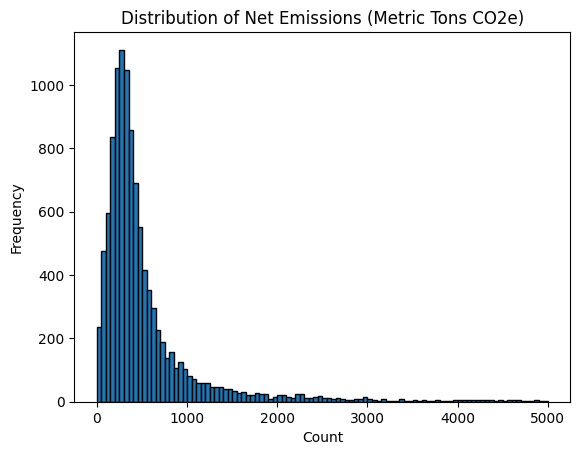

In [ ]:
# distribution of target variable
plt.hist(df['Net Emissions (Metric Tons CO2e)'], range = (0, 5000), bins = 100, edgecolor = 'black');
plt.title('Distribution of Net Emissions (Metric Tons CO2e)');
plt.xlabel('Count');
plt.ylabel('Frequency');

<Axes: >

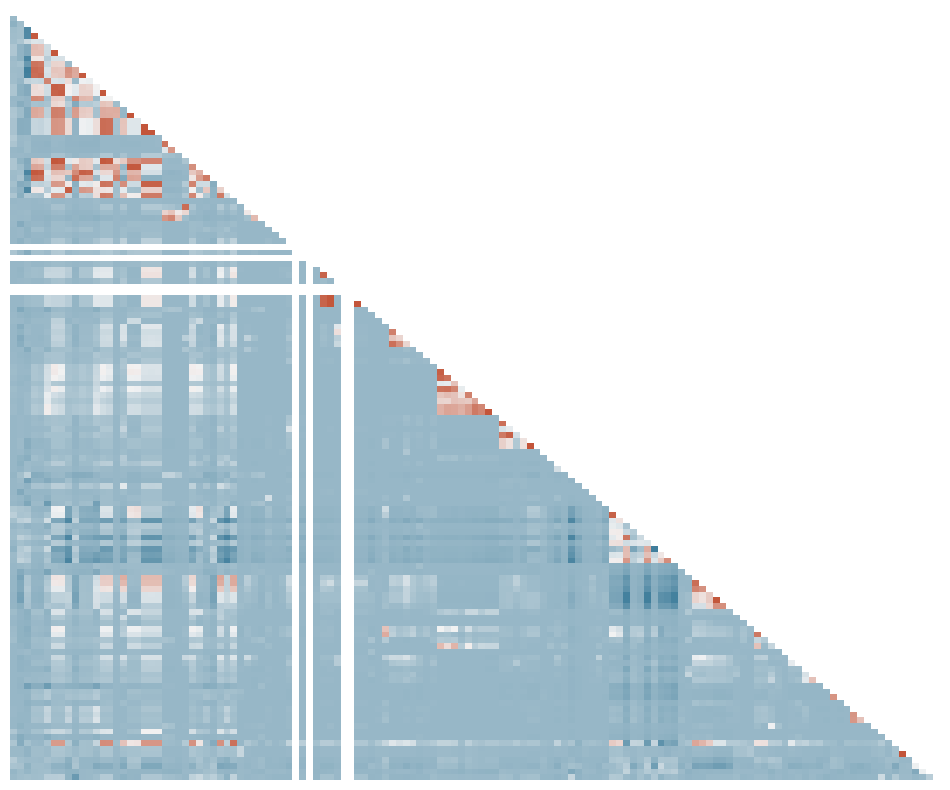

In [ ]:
corr = df[[x for x in df.columns if x != 'Net Emissions (Metric Tons CO2e)']].corr()

# Set up the matplotlib plot configuration

fig, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle

mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap

sns.heatmap(corr, annot=False, mask = mask, cmap=cmap, yticklabels=False, xticklabels = False, cbar=False, linewidths=.001, linecolor='grey')

# Data Preprocessing (encoding)


In [ ]:
# encoding
df = encode(df, categorical_cols)

In [ ]:
# ensure missing value of "Not Available" and NULLS are accounted for
basic_stats(df)

Number of observations:  18125
Number of features/labels:  147
Total cells (col * row): 2664375
Number of NULL entries:  0
Percentage of NULL entries:  0.0
Number of "Not Available" entries:  0
Percentage of "Not Available entries:  0.0


# Linear Models

### For each model
  - Predict with no feature methods
  - SelectKBest with 100, 50, 25, 10
  - PCA with 10, 5, 3, 2, 1, 0.9

In [ ]:
# train test split
x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = None)

# scaling
x_train, x_test = scale(x_train, x_test, numerical_cols)

# basic linear model 
res = eval(LinearRegression(), x_train, y_train, x_test, y_test)
df_res = store(res, 'LinearRegression (no feature methods)')

# basic Ridge model
res = eval(Ridge(), x_train, y_train, x_test, y_test)
df_res = store(res, 'Ridge (no feature methods)', overall_result = df_res)

# basic Lasso model
res = eval(Lasso(), x_train, y_train, x_test, y_test)
df_res = store(res, 'Lasso (no feature methods)', overall_result = df_res)

df_res

,MAE,R^2,Adjusted-R^2,Explained Variance Score
LinearRegression (no feature methods),168169.93558,-3691246.10463,-3900780.34929,-3691244.60297
Ridge (no feature methods),280.12682,0.86510,0.85744,0.86981
Lasso (no feature methods),103.78944,0.86643,0.85884,0.86740


In [ ]:
# range of SelectKBest values
for i in [50, 25, 10]:

    # train test split
    x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = 'SelectKBest', k_best = i)

    # scaling
    x_train, x_test = scale(x_train, x_test, numerical_cols)

    # basic linear model 
    res = eval(LinearRegression(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'LinearRegression (SelectKBest = {})'.format(i), overall_result = df_res)

    # basic Ridge model
    res = eval(Ridge(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Ridge (SelectKBest = {})'.format(i), overall_result = df_res)

    # basic Lasso model
    res = eval(Lasso(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Lasso (SelectKBest = {})'.format(i), overall_result = df_res)

df_res

,MAE,R^2,Adjusted-R^2,Explained Variance Score
LinearRegression (no feature methods),420706.19022,-23155007.47067,-24393531.17957,-23154996.76259
Ridge (no feature methods),388.38310,0.84166,0.83319,0.85309
Lasso (no feature methods),113.78335,0.86967,0.86270,0.87077
LinearRegression (SelectKBest = 50),480.06067,0.63067,0.62375,0.63732
Ridge (SelectKBest = 50),359.55240,0.88479,0.88263,0.89573
Lasso (SelectKBest = 50),114.20781,0.86963,0.86719,0.87072
LinearRegression (SelectKBest = 25),159.14259,0.82792,0.82633,0.82814
Ridge (SelectKBest = 25),231.17769,0.89394,0.89296,0.89679
Lasso (SelectKBest = 25),114.69109,0.86987,0.86866,0.87095
LinearRegression (SelectKBest = 10),52.15094,0.97918,0.97910,0.97918


In [ ]:
# range of PCA component values
for i in [0.5, 0.75, 0.95]:

    # train test split
    x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = 'PCA', n_components = i)

    # scaling
    x_train, x_test = scale(x_train, x_test, numerical_cols)

    # basic linear model 
    res = eval(LinearRegression(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'LinearRegression (PCA = {})'.format(i), overall_result = df_res)

    # basic Ridge model
    res = eval(Ridge(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Ridge (PCA = {})'.format(i), overall_result = df_res)

    # basic Lasso model
    res = eval(Lasso(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Lasso (PCA = {})'.format(i), overall_result = df_res)

df_res

,MAE,R^2,Adjusted-R^2,Explained Variance Score
LinearRegression (no feature methods),420706.19022,-23155007.47067,-24393531.17957,-23154996.76259
Ridge (no feature methods),388.38310,0.84166,0.83319,0.85309
Lasso (no feature methods),113.78335,0.86967,0.86270,0.87077
LinearRegression (SelectKBest = 50),480.06067,0.63067,0.62375,0.63732
Ridge (SelectKBest = 50),359.55240,0.88479,0.88263,0.89573
Lasso (SelectKBest = 50),114.20781,0.86963,0.86719,0.87072
LinearRegression (SelectKBest = 25),159.14259,0.82792,0.82633,0.82814
Ridge (SelectKBest = 25),231.17769,0.89394,0.89296,0.89679
Lasso (SelectKBest = 25),114.69109,0.86987,0.86866,0.87095
LinearRegression (SelectKBest = 10),52.15094,0.97918,0.97910,0.97918


# Modeling on tree based model

- Decision tree
- Random forest
- XGBoost


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# train test split
x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = None)

# scaling
x_train, x_test = scale(x_train, x_test, numerical_cols)

# decision tree model 
res = eval(DecisionTreeRegressor(), x_train, y_train, x_test, y_test)
df_res = store(res, 'Decision Tree (no feature methods)', overall_result = df_res)

# random forest model
res = eval(RandomForestRegressor(), x_train, y_train, x_test, y_test)
df_res = store(res, 'Random Forest (no feature methods)', overall_result = df_res)

# xgboost model
res = eval(xgb.XGBRFRegressor(), x_train, y_train, x_test, y_test)
df_res = store(res, 'XGBoost (no feature methods)', overall_result = df_res)

df_res

,MAE,R^2,Adjusted-R^2,Explained Variance Score
LinearRegression (no feature methods),420706.19022,-23155007.47067,-24393531.17957,-23154996.76259
Ridge (no feature methods),388.38310,0.84166,0.83319,0.85309
Lasso (no feature methods),113.78335,0.86967,0.86270,0.87077
LinearRegression (SelectKBest = 50),480.06067,0.63067,0.62375,0.63732
Ridge (SelectKBest = 50),359.55240,0.88479,0.88263,0.89573
Lasso (SelectKBest = 50),114.20781,0.86963,0.86719,0.87072
LinearRegression (SelectKBest = 25),159.14259,0.82792,0.82633,0.82814
Ridge (SelectKBest = 25),231.17769,0.89394,0.89296,0.89679
Lasso (SelectKBest = 25),114.69109,0.86987,0.86866,0.87095
LinearRegression (SelectKBest = 10),52.15094,0.97918,0.97910,0.97918


In [ ]:
# range of SelectKBest values
for i in [50, 25, 10]:

    # train test split
    x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = 'SelectKBest', k_best = i)

    # scaling
    x_train, x_test = scale(x_train, x_test, numerical_cols)

    # decision tree model 
    res = eval(DecisionTreeRegressor(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Decision Tree (SelectKBest = {})'.format(i), overall_result = df_res)

    # random forest model
    res = eval(RandomForestRegressor(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Random Forest (SelectKBest = {})'.format(i), overall_result = df_res)

    # xgboost model
    res = eval(xgb.XGBRFRegressor(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'XGBoost (SelectKBest = {})'.format(i), overall_result = df_res)

df_res

,MAE,R^2,Adjusted-R^2,Explained Variance Score
LinearRegression (no feature methods),420706.19022,-23155007.47067,-24393531.17957,-23154996.76259
Ridge (no feature methods),388.38310,0.84166,0.83319,0.85309
Lasso (no feature methods),113.78335,0.86967,0.86270,0.87077
LinearRegression (SelectKBest = 50),480.06067,0.63067,0.62375,0.63732
Ridge (SelectKBest = 50),359.55240,0.88479,0.88263,0.89573
Lasso (SelectKBest = 50),114.20781,0.86963,0.86719,0.87072
LinearRegression (SelectKBest = 25),159.14259,0.82792,0.82633,0.82814
Ridge (SelectKBest = 25),231.17769,0.89394,0.89296,0.89679
Lasso (SelectKBest = 25),114.69109,0.86987,0.86866,0.87095
LinearRegression (SelectKBest = 10),52.15094,0.97918,0.97910,0.97918


In [ ]:
# range of PCA component values
for i in [0.5, 0.75, 0.95]:

    # train test split
    x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = 'PCA', n_components = i)

    # scaling
    x_train, x_test = scale(x_train, x_test, numerical_cols)

    # dicision tree model 
    res = eval(DecisionTreeRegressor(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Decision Tree (PCA = {})'.format(i), overall_result = df_res)

    # random forest model
    res = eval(RandomForestRegressor(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'Random Forest (PCA = {})'.format(i), overall_result = df_res)

    # xgboost model
    res = eval(xgb.XGBRFRegressor(), x_train, y_train, x_test, y_test)
    df_res = store(res, 'XGBoost (PCA = {})'.format(i), overall_result = df_res)

df_res

,MAE,R^2,Adjusted-R^2,Explained Variance Score
LinearRegression (no feature methods),420706.19022,-23155007.47067,-24393531.17957,-23154996.76259
Ridge (no feature methods),388.38310,0.84166,0.83319,0.85309
Lasso (no feature methods),113.78335,0.86967,0.86270,0.87077
LinearRegression (SelectKBest = 50),480.06067,0.63067,0.62375,0.63732
Ridge (SelectKBest = 50),359.55240,0.88479,0.88263,0.89573
Lasso (SelectKBest = 50),114.20781,0.86963,0.86719,0.87072
LinearRegression (SelectKBest = 25),159.14259,0.82792,0.82633,0.82814
Ridge (SelectKBest = 25),231.17769,0.89394,0.89296,0.89679
Lasso (SelectKBest = 25),114.69109,0.86987,0.86866,0.87095
LinearRegression (SelectKBest = 10),52.15094,0.97918,0.97910,0.97918


# Model: NN

In [ ]:
# train test split
x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = None)
x_train, x_test = scale(x_train, x_test, numerical_cols)

In [ ]:
mlpr = MLPRegressor(hidden_layer_sizes = (139, 100, 50, 10),learning_rate='adaptive',max_iter=1000, momentum = 0.5, n_iter_no_change =25 ,verbose = True, warm_start=True)
mlpr.fit(x_train, y_train)
y_pred = mlpr.predict(x_test)
r2_score(y_test, y_pred)

Iteration 1, loss = 1682057.43264133
Iteration 2, loss = 1524552.91447481
Iteration 3, loss = 1470055.93115962
Iteration 4, loss = 1389084.85064219
Iteration 5, loss = 1224576.07523265
Iteration 6, loss = 927424.70908486
Iteration 7, loss = 558367.46911761
Iteration 8, loss = 380628.83175569
Iteration 9, loss = 289578.98221826
Iteration 10, loss = 222963.40961345
Iteration 11, loss = 177150.13463881
Iteration 12, loss = 144139.57118408
Iteration 13, loss = 118383.28641478
Iteration 14, loss = 104274.30283840
Iteration 15, loss = 96007.01816452
Iteration 16, loss = 85704.23622692
Iteration 17, loss = 81352.29082009
Iteration 18, loss = 78251.31598559
Iteration 19, loss = 72766.47942023
Iteration 20, loss = 70797.57045216
Iteration 21, loss = 65938.30232761
Iteration 22, loss = 65754.44696403
Iteration 23, loss = 62493.02727104
Iteration 24, loss = 61644.22501861
Iteration 25, loss = 60449.22936614
Iteration 26, loss = 59957.33003890
Iteration 27, loss = 59711.75179184
Iteration 28, loss

0.9213594503057843

In [ ]:
metrics = {'MAE': round(mean_absolute_error(y_test, y_pred),5), #180.92952, 0.91002, 0.90520, 0.91004
           'R^2': round(r2_score(y_test, y_pred),5),
           'Adjusted-R^2': round(1 - ( 1-mlpr.score(x_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - x_test.shape[1] - 1 ), 5),
           'Explained Variance Score': round(explained_variance_score(y_test, y_pred),5)}
df_res = store(metrics, 'MLPR (139, 100, 50, 10)', overall_result = df_res)

# Tune the top 2 models: 
 - Linear Regression with SelectKBest = 10
  - hyper parameters fit_intercept(bool) and positive(bool) changed to other than default results in worse performance.
 - Decision Tree with SelectKBest = 10
  - criterion
  - splitter
  - max_depth
  - min_samples_split
  - min_samples_leaf
  - min_weight_fraction
  - max_features
  - random_state
  - max_leaf_nodes
  - min_impurity_decrease
  - ccp_alpha

In [ ]:
# Initialze the estimators
x_train, x_test, y_train, y_test = tts(df, test_size = 0.15, feat_method = 'SelectKBest', k_best = 10)
x_train, x_test = scale(x_train, x_test, numerical_cols)
parameters={"min_samples_leaf":[1,2,3],
            "min_weight_fraction_leaf":[0, 0.25,0.5,0.75],
            "max_features":["auto","log2","sqrt",None]}
gscv = GridSearchCV(DecisionTreeRegressor(), param_grid = parameters, cv = 5, verbose = 3, scoring = 'r2')

In [ ]:
gscv.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0;, score=0.975 total time=   0.7s
[CV 2/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0;, score=0.932 total time=   0.7s
[CV 3/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0;, score=0.926 total time=   0.6s
[CV 4/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0;, score=0.727 total time=   0.7s
[CV 5/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0;, score=0.813 total time=   0.6s
[CV 1/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0.25;, score=0.154 total time=   0.1s
[CV 2/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0.25;, score=0.121 total time=   0.1s
[CV 3/5] END max_features=auto, min_samples_leaf=1, min_weight_fraction_leaf=0.25;, score=0.080 total time=   0.1s
[CV 4/5] END max_features=auto, m

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_features': ['auto', 'log2', 'sqrt', None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_weight_fraction_leaf': [0, 0.25, 0.5, 0.75]},
             scoring='r2', verbose=3)

In [ ]:
res = eval(gscv.best_estimator_, x_train, y_train, x_test, y_test)
df_res = store(res, 'Decision Tree (Tuned with SKB=10)', overall_result = df_res)
res

{'MAE': 176.7783,
 'R^2': 0.91907,
 'Adjusted-R^2': 0.91862,
 'Explained Variance Score': 0.92277}

In [ ]:
skb = SelectKBest(mutual_info_regression, k=10)
skb.fit(x_train, y_train)
cols_idxs = skb.get_support(indices=True)
df_feat_imp = df.iloc[:,cols_idxs]

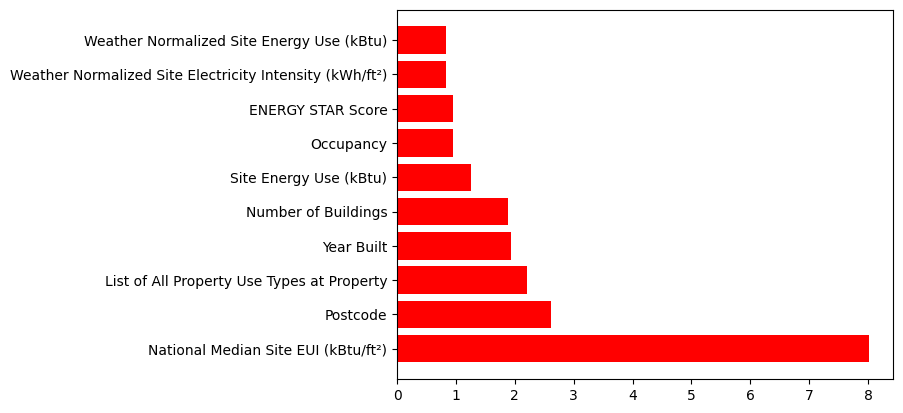

In [ ]:
indices = np.argsort(skb.scores_)[::-1]

# To get your top 10 feature names
features = []
for i in range(10):
    features.append(df.columns[indices[i]])
scores = pd.DataFrame(skb.scores_[indices[range(10)]], columns = ['support'])

# Now plot
plt.figure()
plt.barh(features, scores.support, color='r', align='center')
plt.show()

In [ ]:
# write out and save the results dataframe
df_res.to_csv('ml4clc_res.csv', index = True)
files.download('ml4clc_res.csv')

In [ ]:
def show_bar(x, y, title, xlabel, ylabel, figsize, ylimit_min=0, ylimit_max=0):
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    if ylimit_max != 0:
        plt.ylim(ylimit_min, ylimit_max)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


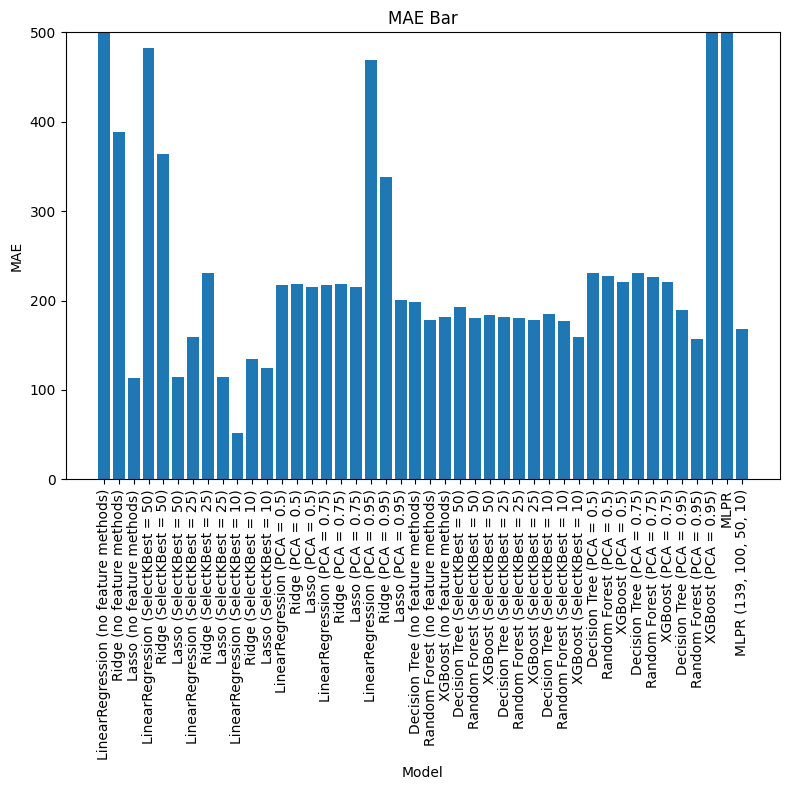

In [ ]:
show_bar(df_res.index, df_res['MAE'], title='MAE Bar', xlabel='Model', ylabel='MAE', figsize=(8, 8), ylimit_max=500)

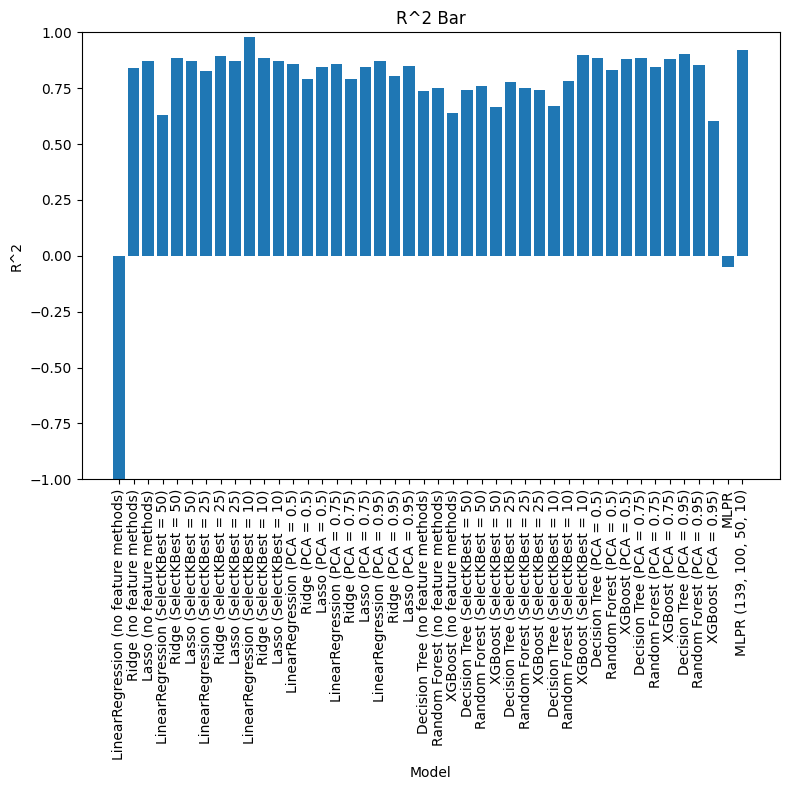

In [ ]:
show_bar(df_res.index, df_res['R^2'], title='R^2 Bar', xlabel='Model', ylabel='R^2', figsize=(8, 8), ylimit_min=-1, ylimit_max=1)

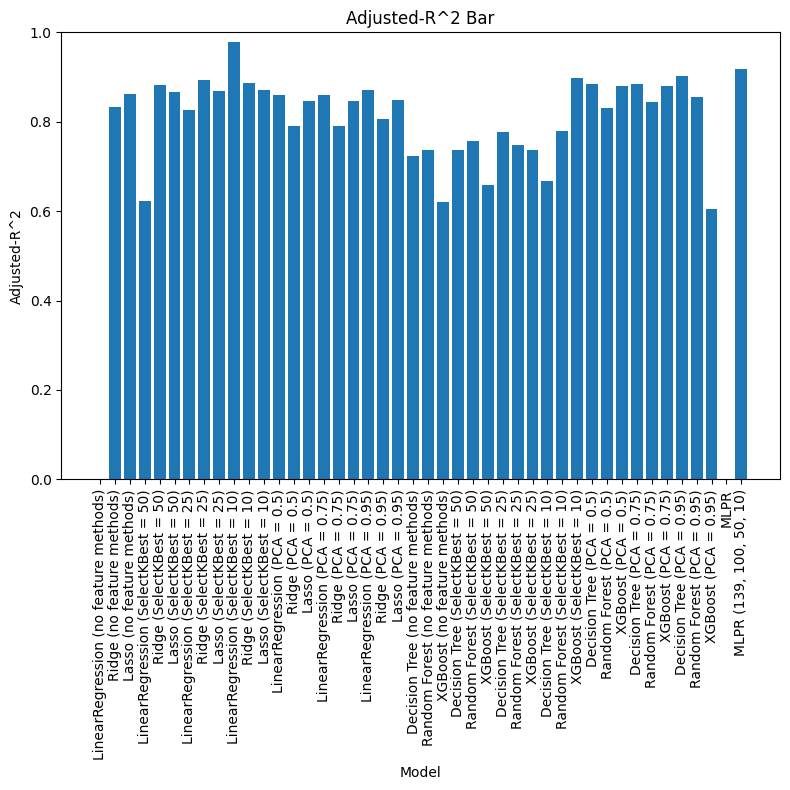

In [ ]:
show_bar(df_res.index, df_res['Adjusted-R^2'], title='Adjusted-R^2 Bar', xlabel='Model', ylabel='Adjusted-R^2', figsize=(8, 8), ylimit_max=1)

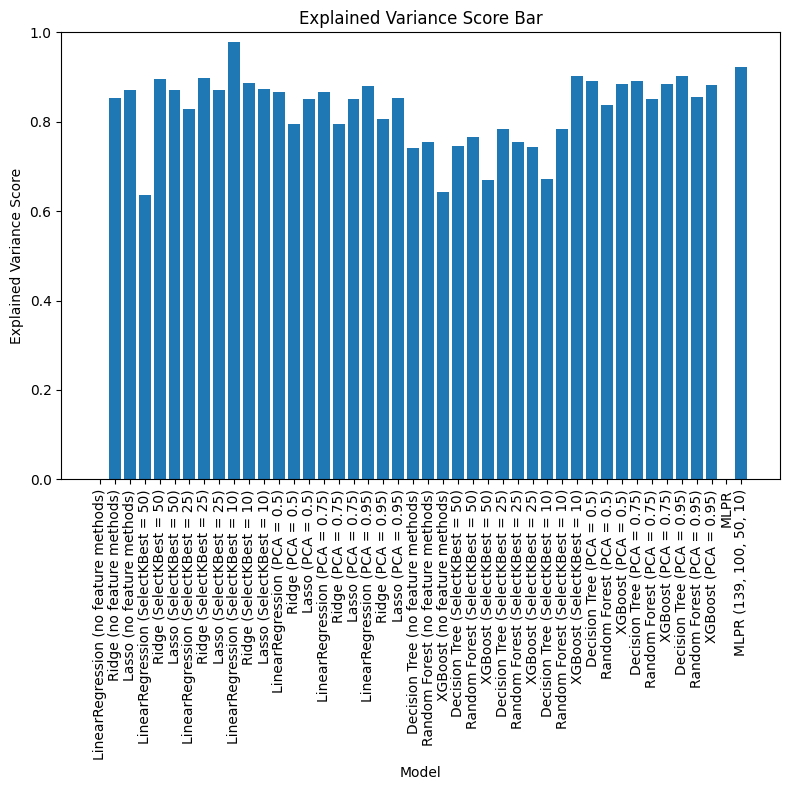

In [ ]:
show_bar(df_res.index, df_res['Explained Variance Score'], title='Explained Variance Score Bar', xlabel='Model', ylabel='Explained Variance Score', figsize=(8, 8), ylimit_max=1)